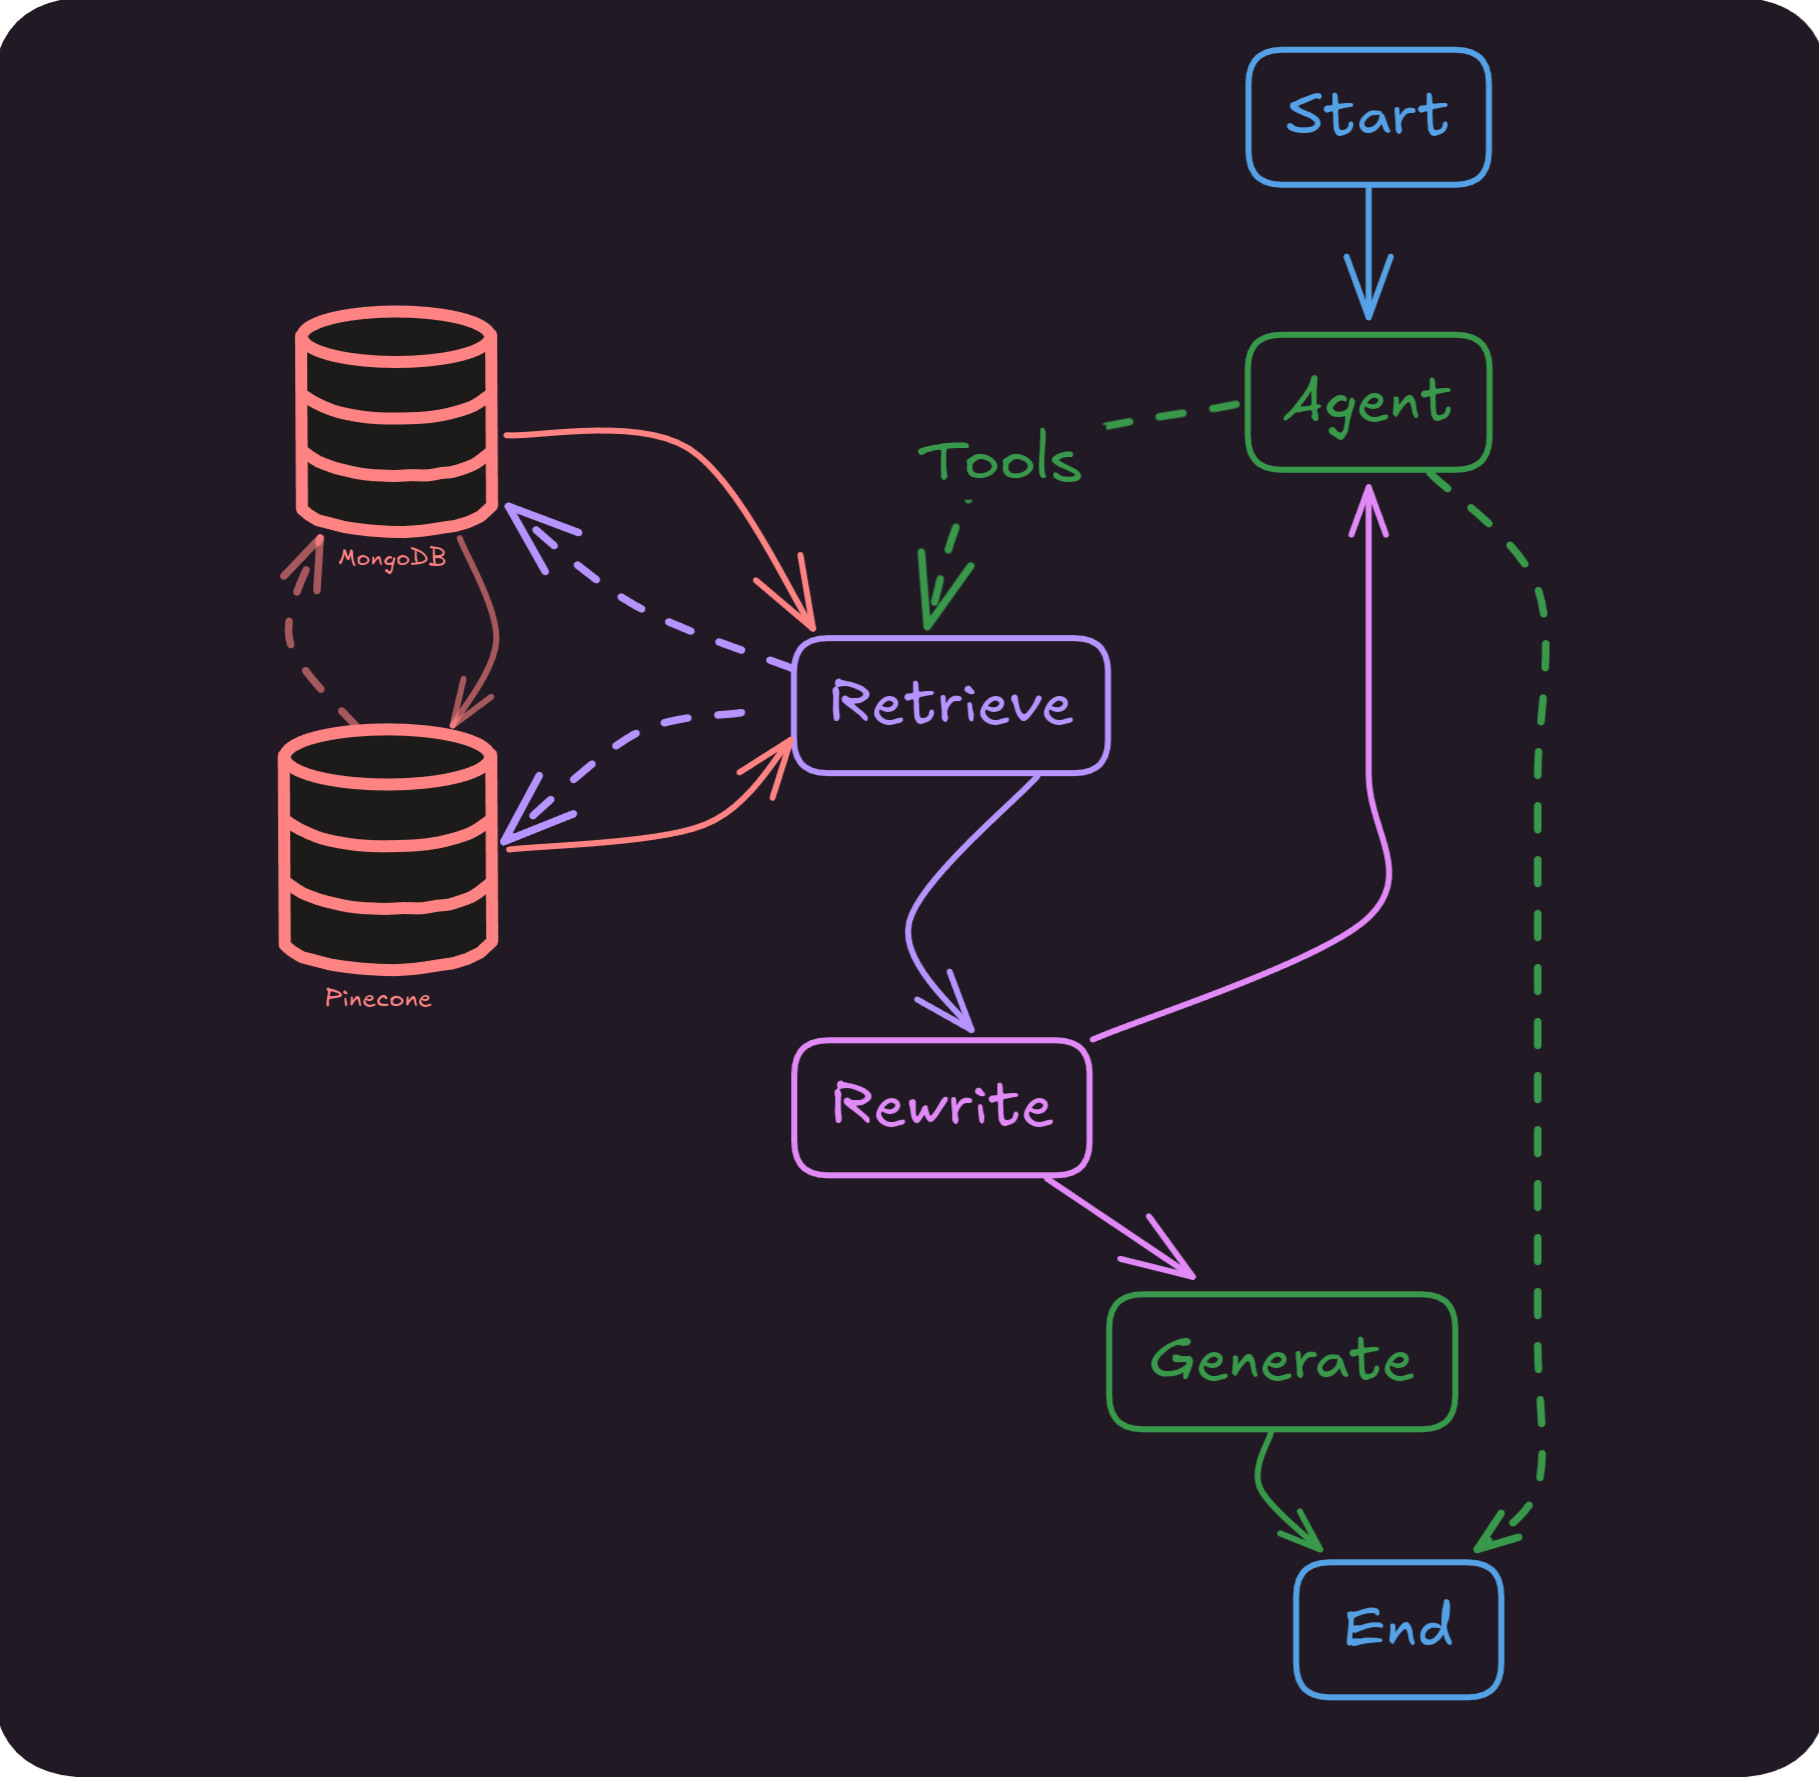

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("COHERE_API_KEY")

In [ ]:
from sentence_transformers import SentenceTransformer, util
from langchain_cohere import ChatCohere
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.message import add_messages
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from data_ingestion import get_index_collection
from bson.objectid import ObjectId
from langchain_core.documents import Document
from IPython.display import Image, display, Markdown

# Initialize embeddings model
embeddings_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Initialize Cohere model
llm = ChatCohere(model="command-r-plus-08-2024")

# Get index and collection from MongoDB
index, collection = get_index_collection()

C:\Users\karba\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Pinged your deployment. You successfully connected to MongoDB!
Duplicates removed successfully.
Unique index on 'title' created successfully.
Documents inserted successfully.


In [ ]:
def retriever(query: str, similar_result: int = 3) -> Document:
    """Retrieve recommended movies title and full plot based on the query."""
    embedding = embeddings_model.encode(query)
    embedding = embedding.tolist()  # Convert from numpy array to list

    result = index.query(vector=embedding, top_k=similar_result)

    combined_information = ""
    for match in result["matches"]:
        value = match['id']
        fullplot = collection.find_one({"_id": ObjectId(value)})["fullplot"]
        title = collection.find_one({"_id": ObjectId(value)})["title"]
        combined_information += f"Title: {title}, Fullplot: {fullplot}\n"

    return combined_information

# Define tools
tools = [retriever]

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Define a new graph
workflow = StateGraph(AgentState)

In [ ]:
def agent(state: AgentState):
    """Invoke the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool,
    or simply pass the message to passquery if there is no movie related query.
    use retriever tool for movie related query only.
    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages"""
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatCohere(model="command-r-plus-08-2024").bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

workflow.add_node("agent", agent)

In [ ]:
retrieve = ToolNode([retriever])
workflow.add_node("retrieve", retrieve)

In [ ]:
def rewrite(state: AgentState):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f"""
            Look at the input and try to reason about the underlying semantic intent / meaning.
            Here is the initial question:
            -------
            {question}
            -------
            Formulate an improved question: """,
        )
    ]
    return {"messages": msg}

workflow.add_node("rewrite", rewrite)

In [ ]:
def generate(state: AgentState):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Model
    prompt = PromptTemplate(
        template="Here is the context: {context}\nAnd the question: {question}\nGenerate a response by each selected movie title and why?.And each movie reaon also is piont under each movie points",

        input_variables=["context", "question"]
    )
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}
workflow.add_node("generate", generate)

In [ ]:
def grade_documents(state: AgentState) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """
    print("---CHECK RELEVANCE---")

    class Grade(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatCohere(model="command-r-plus-08-2024").with_structured_output(Grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question.
        Here is the retrieved document:
        {context}
        Here is the user question: {question}
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | model
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [ ]:
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")
# Compile the workflow
graph = workflow.compile()

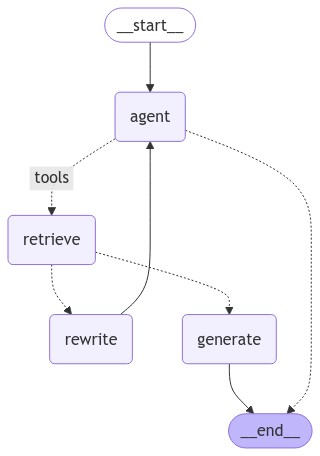

In [ ]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# Example input
inputs = {
    "messages": [
        ("user", "What is the best horror movie to watch and why?"),
    ]
}

# Stream the output
import pprint
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='I will search for the best horror movie to watch.', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'c1b5b51f-b93a-4c20-bc59-6ca28e6183d0', 'tool_calls': [{'id': '4da19c7f18f94a1e9d5541ed23ebb55d', 'function': {'name': 'retriever', 'arguments': '{"query": "best horror movie to watch"}'}, 'type': 'function'}], 'token_count': {'input_tokens': 923.0, 'output_tokens': 56.0}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'c1b5b51f-b93a-4c20-bc59-6ca28e6183d0', 'tool_calls': [{'id': '4da19c7f18f94a1e9d5541ed23ebb55d', 'function': {'name': 'retriever', 'arguments': '{"query": "best horror movie to watch"}'}, 'type': 'function'}], 'token_count': {'input_tokens': 923.0, 'output_tokens': 56.0}}, id='run-ac5e

In [ ]:
display(Markdown(output['generate']['messages'][0]))

## Cobra:
- **Intense Action and Thriller Elements:** 'Cobra' is a high-octane action thriller that delivers a relentless pursuit of justice against a gang of neo-fascist killers. The movie's fast-paced nature, combined with Sylvester Stallone's iconic portrayal of Lt. Marian Cobretti, creates an engaging and adrenaline-pumping experience.
- **Gritty Realism:** The film offers a gritty and dark portrayal of urban crime, showcasing the brutality and randomness of the thugs' killings. This realism adds a layer of fear and suspense, making the audience feel the danger and urgency of the situation.
- **Unpredictable Plot Twists:** 'Cobra' keeps viewers on the edge of their seats with unexpected plot developments. The constant threat to the witness, Ingrid, and Cobretti himself creates a sense of impending doom, making it a thrilling ride.

## Biteu:
- **Exploration of the Underworld:** While not a traditional horror movie, 'Biteu' delves into the dark and gritty world of the Korean mob. The film's depiction of the criminal underworld, filled with violence and moral ambiguity, can evoke a sense of dread and unease.
- **Character-Driven Suspense:** The story's focus on Min's journey and his complex relationships adds a layer of tension. His involvement with the mob and his romance with Romi from a different social class create a compelling narrative that keeps viewers invested.
- **Social Commentary:** 'Biteu' offers a commentary on class struggle and the impact of societal pressures on youth. The characters' decisions and the consequences they face can provide a thought-provoking experience, adding depth to the horror genre.

## Cowboys & Aliens:
- **Unique Blend of Genres:** 'Cowboys & Aliens' combines elements of the Western and science fiction genres, creating a fresh and exciting take on horror. The unexpected clash of cowboys and extraterrestrial invaders provides a visually stunning and conceptually intriguing experience.
- **Iconic Cast and Action Sequences:** With a stellar cast, including Daniel Craig and Harrison Ford, the movie delivers intense and well-choreographed action scenes. The showdown between the cowboys and aliens is thrilling, offering a unique twist on the typical horror monster encounter.
- **Suspense and Mystery:** The stranger's amnesiac state and the town's fear-ridden atmosphere build suspense. As the stranger gradually uncovers his past, the audience is treated to a compelling mystery, adding depth to the horror elements.

In conclusion, while all three movies offer unique experiences, 'Cobra' stands out as the best horror movie in this context due to its intense action, gritty realism, and unpredictable plot twists, ensuring a thrilling and suspenseful viewing experience.

In [ ]:
inputs = {
    "messages": [
        ("user", "top 5 horror and action movie"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='I will search for the top 5 horror and action movies.', additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '7fd58279-b7ed-4810-999a-4d46112e5ac2', 'tool_calls': [{'id': 'f2cf414bc64744a9add5527899dc2005', 'function': {'name': 'retriever', 'arguments': '{"query": "top 5 horror and action movie"}'}, 'type': 'function'}], 'token_count': {'input_tokens': 919.0, 'output_tokens': 60.0}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': '7fd58279-b7ed-4810-999a-4d46112e5ac2', 'tool_calls': [{'id': 'f2cf414bc64744a9add5527899dc2005', 'function': {'name': 'retriever', 'arguments': '{"query": "top 5 horror and action movie"}'}, 'type': 'function'}], 'token_count': {'input_tokens': 919.0, 'output_tokens': 60.0}}, id

In [ ]:
display(Markdown(output['generate']['messages'][0]))

Here are the top 5 horror and action movies based on the provided context, along with reasons for their selection:

1. **Biteu**:
   - Horror Element: The movie explores the dark and violent underworld of the Korean mob, which can create a sense of horror and unease. The portrayal of gang life, including potential acts of brutality and the psychological impact on Min, could evoke fear and tension.
   - Action Aspect: With a storyline involving mob activities, 'Biteu' likely features intense action sequences. These may include fights, chases, and potentially life-threatening situations as Min navigates the criminal underworld, providing a thrilling and action-packed experience.

2. **Thursday**:
   - Horror Element: This film opens with a chilling scene in a convenience store, setting the tone for a tense and violent narrative. The casual killing of an innocent cashier and the subsequent cover-up create a sense of dread and horror. The presence of hitmen and their ruthless actions contribute to the overall horror theme.
   - Action Element: The movie showcases action-packed sequences, including shootouts, chases, and the constant sense of danger. The characters' lives are at stake, leading to high-octane moments and a fast-paced narrative that will keep viewers on the edge of their seats.

3. **F/X**:
   - Horror Element: While not a traditional horror movie, 'F/X' incorporates elements of suspense and psychological horror. The double-crossing by a government agency and the protagonist's subsequent entrapment can create a sense of paranoia and fear. The potential for violence and the manipulation of reality through special effects add to the horror atmosphere.
   - Action Element: The movie promises action as the protagonist, a special effects expert, takes on a corrupt government agency and gangsters. This setup likely involves elaborate stunts, chases, and clever use of special effects to create thrilling action sequences.

---

Due to the limited context provided, I was unable to identify two additional movies to complete the top 5 list. However, I can provide alternative horror and action movie recommendations if you'd like, or you can provide additional movie titles and plots for further analysis.

In [ ]:
inputs = {
    "messages": [
        ("user", "What is RAG"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="I'm sorry, I don't know what RAG is.", additional_kwargs={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'be024432-3cec-4b41-8ea6-0e180b3c1f5a', 'token_count': {'input_tokens': 916.0, 'output_tokens': 94.0}}, response_metadata={'documents': None, 'citations': None, 'search_results': None, 'search_queries': None, 'is_search_required': None, 'generation_id': 'be024432-3cec-4b41-8ea6-0e180b3c1f5a', 'token_count': {'input_tokens': 916.0, 'output_tokens': 94.0}}, id='run-bf8dfb7f-7f2e-470c-ac6c-6c1ad53015b1-0', usage_metadata={'input_tokens': 916, 'output_tokens': 94, 'total_tokens': 1010})]}
'\n---\n'


In [ ]:
display(Markdown(output['agent']['messages'][0].content))

I'm sorry, I don't know what RAG is.